In [1]:
%matplotlib inline
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization, UpSampling2D,Concatenate, Activation,Add, Dense, Flatten, Cropping2D
from keras import backend as K
from keras import optimizers
from keras.applications.resnet50 import ResNet50

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from skimage.io import imsave, imread
from skimage.transform import resize

import os.path
from glob import glob
import pickle, pprint, csv

Using TensorFlow backend.


# Loading Data

In [2]:
img_size_ori = 101
img_size_target = 197




train_label = {}
with open('../data/train/train_label_v2.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        train_label[row[0]]= row[1]

In [3]:
images = []
labels = []

train_data_path = '../data/train'

# for image_name in train_label:
#     print (key, 'label value', train_label[key])
    
#     img = imread(os.path.join(train_data_path, image_name + '.png'), as_gray=False)
    
#     if img_size_ori != img_size_target:
#         img = resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
#     label = train_label[image_name]
    
#     images.append(img)
#     labels.append(label)


image_paths = glob(os.path.join(train_data_path, 'images', '*.png'))


for image_path in image_paths:

    #img = imread(image_path, as_gray=False)
    img = np.array(load_img(image_path))

    if img_size_ori != img_size_target:
        img = resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    #Get label value
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]        
    label = train_label[image_name]
            
    images.append(img)
    labels.append(label)  
    
    if label == 'N':
        images.append(np.fliplr(img))
        labels.append(label) 
    
    

images = np.array(images)
labels = np.array(labels)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
images[0].shape

(197, 197, 3)

In [5]:
len(images)

5562

In [6]:
labels[0]

'Y'

In [7]:
#sns.distplot(labels.argmax(axis=1))

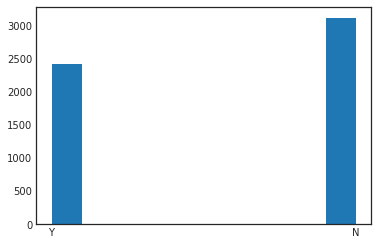

In [8]:
m =plt.hist(labels)

        

# Create train/validation split

In [9]:
from sklearn.utils import shuffle

images, labels = shuffle(images, labels)


# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, validX, trainY, validY) = train_test_split(images, labels,
test_size=0.25, random_state=42)

trainX = trainX.astype("float")
validX = validX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX /= 255
validX /= 255

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
#validY = lb.fit_transform(validY)
validY = lb.transform(validY)



In [10]:
trainX.shape

(4171, 197, 197, 3)

(array([789.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 602.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

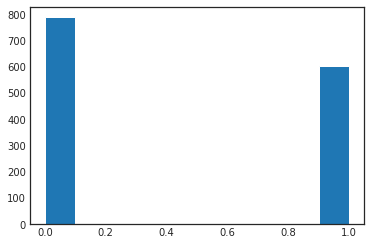

In [11]:
plt.hist(validY)

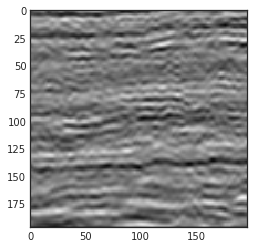

In [12]:
plt.imshow(images[3].astype(np.uint8))

In [13]:
# from keras.models import Sequential
# model = Sequential([
#     Conv2D(32,(3, 3), activation = 'relu', input_shape=(197,197,3)),
#     Flatten(),
#     Dense(1, activation="softmax")
# ])

In [14]:
#model = architecture()
# model.summary()

In [15]:
# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# model.fit(trainX, trainY, batch_size=10, epochs=5)

In [16]:
# resnet50_model = ResNet50(include_top=True, weights='imagenet', input_tensor=None, pooling=None)

In [17]:
# resnet50_model.summary()

In [18]:
# resnet50_model.get_config()

In [19]:
#Build model for 197 input. The problem was upscale
def build_model(input_layer, start_neurons, base_model, DropoutRatio = 0.5):

    # Get Resnet
    #resnet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= input_layer, pooling=None)
    
    #base_model.layers.pop()
    
    for layer in base_model.layers[:141]: #141
        layer.trainable = True   

    avgPool = base_model.layers[173].output
    flatten = Flatten()(avgPool)
    drp1 = Dropout(DropoutRatio)
    dense1 = Dense(1024, activation="relu")(flatten)
    drp2 = Dropout(DropoutRatio)(dense1)
    output_layer = Dense(1, activation="sigmoid")(drp2)
    
    model = Model(base_model.input, output_layer)
    return model

In [20]:
input_layer = (img_size_target, img_size_target, 3)
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape= input_layer, pooling=None, )


In [21]:
model1 = build_model(input_layer, 64,resnet50_model, 0.5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [23]:
#model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
#model1.fit(trainX, trainY, batch_size=32, epochs=5)

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer=sgd)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras_classfier.model", save_best_only=True, verbose=2)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=2)

epochs = 50
batch_size = 32

history = model1.fit(trainX, trainY,
                    validation_data=[validX, validY], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 4171 samples, validate on 1391 samples
Epoch 1/50
4171/4171 [==============================] - 97s 23ms/step - loss: 0.4202 - acc: 0.8164 - val_loss: 4.5544 - val_acc: 0.5672
Epoch 2/50
4171/4171 [==============================] - 59s 14ms/step - loss: 0.2634 - acc: 0.8924 - val_loss: 1.7335 - val_acc: 0.5672
Epoch 3/50
4171/4171 [==============================] - 59s 14ms/step - loss: 0.1727 - acc: 0.9314 - val_loss: 1.0675 - val_acc: 0.5636
Epoch 4/50
4171/4171 [==============================] - 59s 14ms/step - loss: 0.1337 - acc: 0.9497 - val_loss: 1.0939 - val_acc: 0.4493
Epoch 5/50
4171/4171 [==============================] - 60s 14ms/step - loss: 0.0787 - acc: 0.9741 - val_loss: 0.9890 - val_acc: 0.5607
Epoch 6/50
4171/4171 [==============================] - 59s 14ms/step - loss: 0.0468 - acc: 0.9856 - val_loss: 0.8565 - val_acc: 0.5960
Epoch 7/50
4171/4171 [==============================] - 59s 14ms/step - loss: 0.0415 - acc: 0.9854 - val_loss: 0.5028 - val_acc: 0.7951


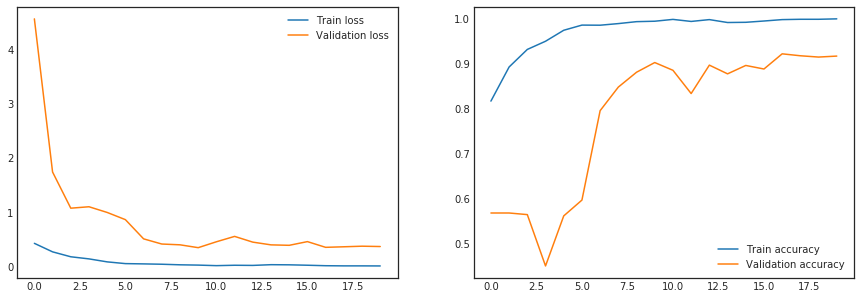

In [25]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [26]:
#predict = model.predict(validX)

In [27]:
#predict[0]

In [28]:
labelNames = ['No','Yes']
# evaluate the network
print("[INFO] evaluating network...")
predictions = model1.predict(validX, batch_size=32)


[INFO] evaluating network...


In [29]:
print(classification_report(validY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=labelNames))

             precision    recall  f1-score   support

         No       1.00      1.00      1.00      1391

avg / total       1.00      1.00      1.00      1391



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


In [30]:
validY.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
predictions

array([[5.8454630e-04],
       [9.9998605e-01],
       [6.9902824e-05],
       ...,
       [2.3568684e-05],
       [1.6538479e-04],
       [1.0000000e+00]], dtype=float32)

In [32]:
#predictions = model1.predict_classes(validX, batch_size=32)

In [33]:
predictions

array([[5.8454630e-04],
       [9.9998605e-01],
       [6.9902824e-05],
       ...,
       [2.3568684e-05],
       [1.6538479e-04],
       [1.0000000e+00]], dtype=float32)

In [34]:
validY.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
validY

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [36]:
df = pd.DataFrame({'predictions':predictions[:,0], 'ground_true':validY[:,0]})

In [37]:
df

,ground_true,predictions
0,0,5.845463e-04
1,1,9.999861e-01
2,0,6.990282e-05
3,0,1.061914e-06
4,1,9.993092e-01
5,0,7.339834e-03
6,1,9.826353e-01
7,0,1.370384e-02
8,1,9.999648e-01
9,1,9.999980e-01


In [40]:
#df.to_csv('prevVStrue.csv')
from tqdm import tqdm_notebook

In [43]:
image_paths = glob(os.path.join('../data/test', 'images', '*.png'))

images_test = []
images_name = []

for image_path in image_paths:

    #img = imread(image_path, as_gray=False)
    img = np.array(load_img(image_path))

    if img_size_ori != img_size_target:
        img = resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    #Get label value
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]        
           
    images_test.append(img)
    images_name.append(image_name) 
    
    

images_test = np.array(images_test)
images_name = np.array(images_name)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [44]:
images_test = images_test.astype("float")
images_test /= 255

In [45]:
predictions2 = model1.predict(images_test, batch_size=32)

In [47]:
predictions2

array([[0.999998  ],
       [0.594897  ],
       [0.999995  ],
       ...,
       [1.        ],
       [0.9996841 ],
       [0.02430974]], dtype=float32)

In [50]:
df = pd.DataFrame({'id':images_name[:], 'predictions':predictions2[:,0]})

In [51]:
df

,id,predictions
0,3cca3f86b6,0.999998
1,7cfbd6059d,0.594897
2,05ef6e7154,0.999995
3,fcb75e949a,1.000000
4,4b532df3df,0.999976
5,065d95e8dc,0.941254
6,6db4d1afbe,0.000092
7,e202f8d4df,0.001156
8,3c1ee5b008,1.000000
9,1113401d3c,0.876849


In [52]:
df.to_csv('imagefromclassifier_v3.csv')